In [1]:
import numpy as np
import time
from imageio import imread
import matplotlib.pyplot as plt

from scipy.fftpack import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage.filters import convolve

(512, 512)


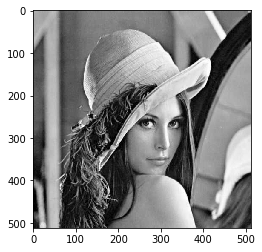

In [2]:
im = imread("../../samples/lena.jpg", pilmode="L")
plt.imshow(im, cmap="gray")
print(im.shape)
plt.show()

# Exercise 4: Filtering in Frequency Domain

The Fourier transformation in the descrete domain is defined as:

$$
\begin{align}
F(u,v)
    &= \sum_{x=0}^{M}\sum_{y=0}^{N}f(x,y) \cdot e^{-2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)} \\
    &= \sum_{x=0}^{M}\sum_{y=0}^{N} \dfrac{f(x,y)}{e^{2i\pi\cdot\left(\dfrac{u \cdot x}{M} + \dfrac{v \cdot y}{N} \right)}} \\
e^{i \cdot \rho \cdot x} 
    &= \mathrm{cos}(\rho \cdot x) + i\cdot \mathrm{sin}(\rho \cdot x)
\end{align}
$$




## Task 2 - Filtering in Frequency Domain

1. Implement a functions, that performs the linear filtering in the frequency domain. The inputs of this function should be the **image** and the **filter mask** in the *spatial domain*! 
2. Visualize the runtimes of your function with the runtimes of <code>scipy.ndimage.filters.convolve</code> for different filter sizes!
3. Compare the results of the both functions qualitatively and quantitavely (*MAP error*)!

In [3]:
def normalize(im):
    """
        Small helper function for image renormalization
    """
    im = im.astype(np.float32)
    im -= im.min()
    im /= im.max()
    return im
    

def DFT(im, shift=False):
    if im.dtype == np.uint8:
        im = im.astype(np.float) / 255
    
    I = fft2(im)
    if shift:
        I = fftshift(I)
    
    return I

def iDFT(I, shift=False, norm=False):
    if shift:
        I = ifftshift(I)
    
    im = ifft2(I)
    if norm:
        im = normalize(im.real)
    else:
        im = im.real
    im = np.round(im * 255)
    
    return im.astype(np.uint8)

In [4]:
def imfilter_FFT(im, mask):
    h, w = im.shape
    f_h, f_w = mask.shape
    d_h, d_w = h - f_h, w - f_w
    
    padding =[
        (
            int(np.ceil(d_h / 2)),
            int(np.floor(d_h / 2)),
        ), (
            int(np.ceil(d_w / 2)),
            int(np.floor(d_w / 2)),
        )
    ]    
    
    Im = DFT(im)
    mask = fftshift(np.pad(mask, padding, mode="constant"))
    F = DFT(mask)
    res = iDFT(Im * F)
    return res

def box_filter(size):
    return np.ones((size, size)) / size**2

/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


CPU times: user 148 ms, sys: 41.1 ms, total: 189 ms
Wall time: 48.9 ms
CPU times: user 53 ms, sys: 0 ns, total: 53 ms
Wall time: 13.2 ms
0.5000458


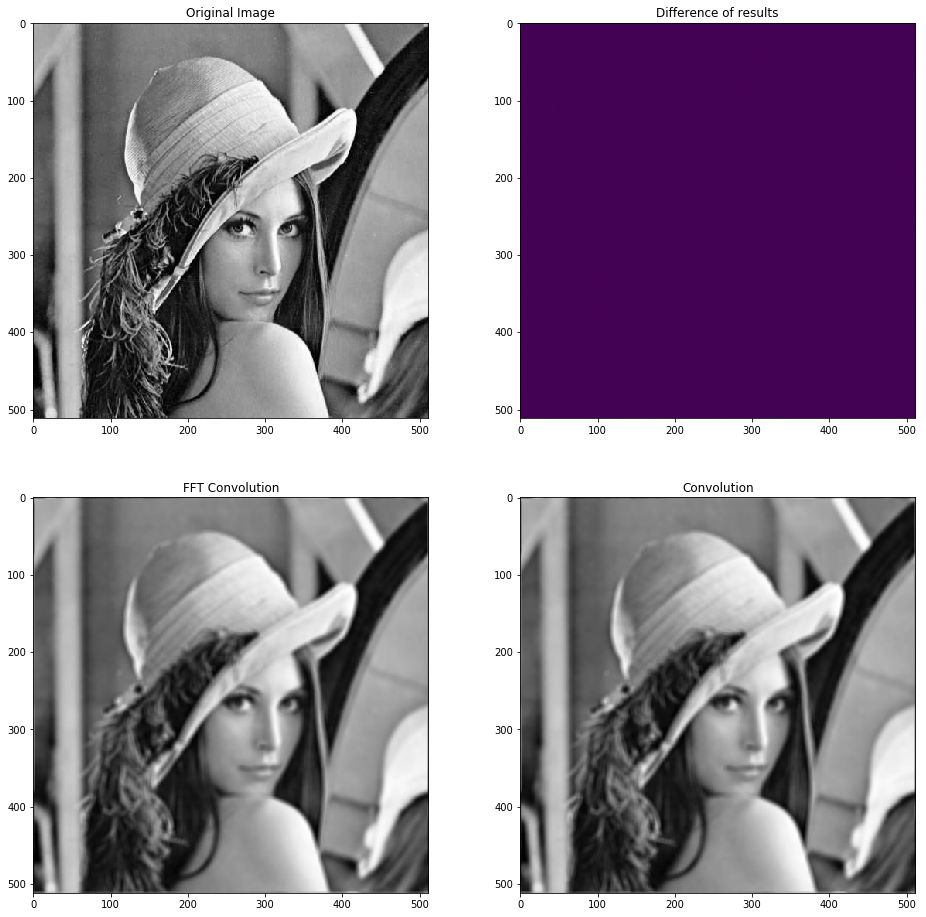

In [5]:
size = 7
B = box_filter(size)

_im = im.copy()

%time im0 = imfilter_FFT(_im, B).astype(np.uint8)
%time im1 = convolve(_im, B, mode="wrap")

diff =np.abs(im0.astype(np.float32) - im1.astype(np.float32))
print(diff.mean())

fig, axs = plt.subplots(2,2, figsize=(16, 16))

axs[0,0].imshow(_im, cmap=plt.cm.gray)
axs[0,0].set_title("Original Image")

axs[0,1].imshow(diff, vmin=0, vmax=255)
axs[0,1].set_title("Difference of results")

axs[1,0].imshow(im0, cmap=plt.cm.gray)
axs[1,0].set_title("FFT Convolution")

axs[1,1].imshow(im1, cmap=plt.cm.gray)
axs[1,1].set_title("Convolution")


plt.show()
plt.close()

/home/korsch/.anaconda3/envs/chainer4/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


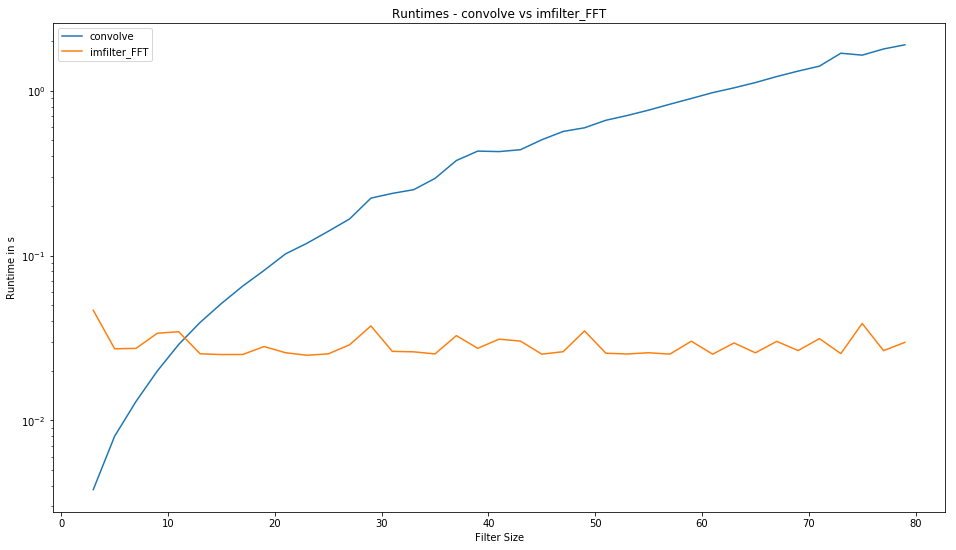

In [6]:
def plot_runtimes(im, sizes, func1, func2):
    xs = sizes
    ys_f1 = []
    ys_f2 = []
    
    for size in sizes:
        filter_mask = box_filter(size)
        
        t0 = time.time()
        _res = func1(im, filter_mask)
        t1 = time.time()
        ys_f1.append(t1 - t0)
        
        t0 = time.time()
        _res = func2(im, filter_mask)
        t1 = time.time()
        ys_f2.append(t1 - t0)
        
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    ax.set_title(f"Runtimes - {func1.__name__} vs {func2.__name__}")
    ax.set_xlabel("Filter Size")
    ax.set_ylabel("Runtime in s")
    ax.set_yscale("log")
    
    ax.plot(xs, ys_f1, label=f"{func1.__name__}")
    ax.plot(xs, ys_f2, label=f"{func2.__name__}")
    
    ax.legend()
    
    plt.show()
    plt.close()

sizes = np.arange(3, 80, step=2)
plot_runtimes(im, sizes, convolve, imfilter_FFT)